In [1]:
import os
import pandas as pd
import numpy as np
import itertools
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


2023-09-15 09:39:22.775717: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-15 09:39:24.449858: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-15 09:39:24.450426: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-15 09:39:29.749697: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
DATA_DIR = './dms_data'
def load_and_preprocess_data(file_path):
    """CSVを読み込んでちょっと前処理する関数。"""
    df = pd.read_csv(file_path)
    df = df.drop(['timestamp'], axis=1)
    return df.dropna()

def get_data_from_directory(directory_path):
    """指定ディレクトリのCSV全部を読み込んで結合する関数。"""
    files = [f for f in os.listdir(directory_path) if f.endswith('.csv')]
    data_frames = [load_and_preprocess_data(os.path.join(directory_path, file)) for file in files]
    return pd.concat(data_frames, ignore_index=True)

def showLgbmModelFeature(model):
    plt.figure(figsize=(10,6))
    lgb.plot_importance(model)
    plt.show()

# トレインデータとテストデータを読み込む
train = get_data_from_directory(os.path.join(DATA_DIR, 'train'))
test = get_data_from_directory(os.path.join(DATA_DIR, 'test'))

# 特徴量を定義
features = [
    'm_speed', 'm_speed_var_480', 'm_speed_stddev_480', 'm_acceleration',
    'm_acceleration_var_480', 'm_acceleration_stddev_480', 'm_jerk',
    'm_jerk_var_480', 'm_jerk_stddev_480'
]

In [3]:
def evaluate_predictions(predicted_labels, true_labels):
    # Accuracy
    acc = accuracy_score(true_labels, predicted_labels)
    print(f"Accuracy: {acc:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Other statistics (Precision, Recall, F1-score)
    print("\nClassification Report:\n")
    print(classification_report(true_labels, predicted_labels))

    return acc

# 使用例
# acc_value = evaluate_predictions(predicted_labels, y_test_oss)


In [4]:
# ossを丸めてint型として新しいカラムoss_intを追加
train['int_oss'] = train['oss'].round().astype(int)
train['int_sleepiness'] = train['Sleepiness'].round().astype(int)
test['int_oss'] = test['oss'].round().astype(int)
test['int_sleepiness'] = test['Sleepiness'].round().astype(int)

### LightGBM

In [5]:
def train_lgbm_classificatoin(num_class,train,test):
    params = {
    'objective': 'multiclass', # 多クラス分類
    'num_class': num_class, # クラスの数
    'metric': 'multi_logloss' # 損失関数にmulti_loglossを使用
    }
    model = lgb.train(params, train, num_boost_round=1000, valid_sets=[train,test], early_stopping_rounds=10)
    return model


/home/buntin/jupyter-env/lib64/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000584 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5462
[LightGBM] [Info] Number of data points in the train set: 1738, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -1.491783
[LightGBM] [Info] Start training from score -0.573959
[LightGBM] [Info] Start training from score -1.847362
[LightGBM] [Info] Start training from score -2.917196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's multi_logloss: 0.947342	valid_1's multi_logloss: 1.40269
Training until validation scores don't improve for 10 rounds
[2]	training's multi_logloss: 0.841149	valid_1's multi_logloss: 1.3184

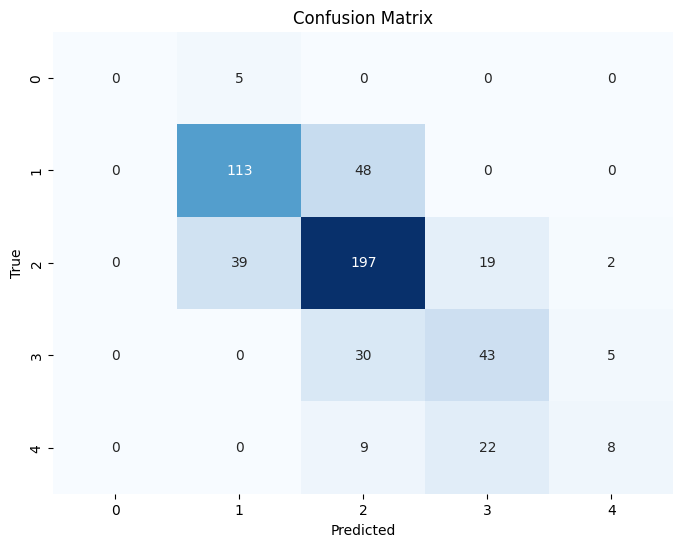


Classification Report:

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         5
           2       0.72      0.70      0.71       161
           3       0.69      0.77      0.73       257
           4       0.51      0.55      0.53        78
           5       0.53      0.21      0.30        39

    accuracy                           0.67       540
   macro avg       0.49      0.44      0.45       540
weighted avg       0.66      0.67      0.66       540



/home/buntin/jupyter-env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/buntin/jupyter-env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/buntin/jupyter-env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
# int_oss
from sklearn.metrics import accuracy_score

X_train_oss = train.drop('int_oss', axis=1).drop('oss',axis=1)
y_train_oss = train['int_oss']
y_train_oss -= 1

X_test_oss = test.drop('int_oss', axis=1).drop('oss',axis=1)
y_test_oss = test['int_oss']
y_test_oss -= 1

train_data_oss = lgb.Dataset(X_train_oss, label=y_train_oss)
test_data_oss = lgb.Dataset(X_test_oss, label=y_test_oss, reference=train_data_oss)

model = train_lgbm_classificatoin(5,train_data_oss,test_data_oss)

y_pred_oss = model.predict(X_test_oss)
y_pred_oss_class = np.argmax(y_pred_oss,axis=1) + 1
y_test_oss += 1

acc = accuracy_score(y_test_oss,y_pred_oss_class)
print('Accuracy:', acc)
acc = evaluate_predictions(y_pred_oss_class, y_test_oss)


<Figure size 1000x600 with 0 Axes>

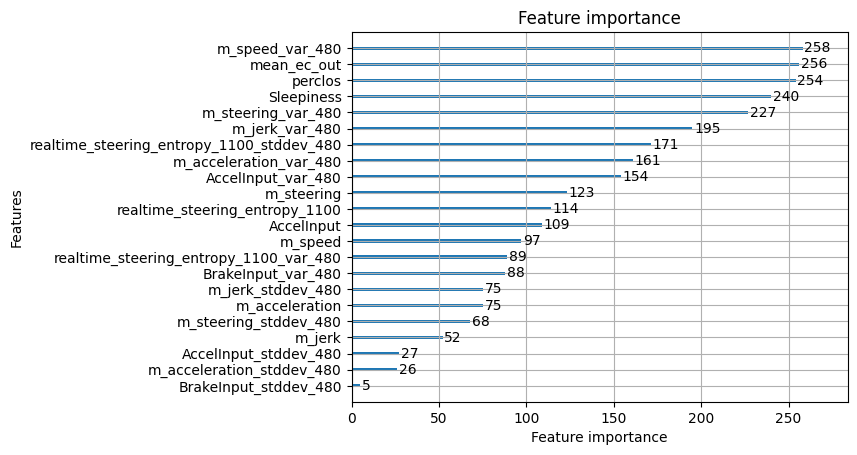

: 

: 

In [ ]:
showLgbmModelFeature(model)

/home/buntin/jupyter-env/lib64/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5458
[LightGBM] [Info] Number of data points in the train set: 1738, number of used features: 24
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -6.767343
[LightGBM] [Info] Start training from score -3.528665
[LightGBM] [Info] Start training from score -2.273104
[LightGBM] [Info] Start training from score -1.733643
[LightGBM] [Info] Start training from score -1.794064
[LightGBM] [Info] Start training from score -1.794064
[LightGBM] [Info] Start training from score -1.829279
[LightGBM] [Info] Start training from score -2.094514
[LightGBM] [Info] Start training from score -2.608460
[LightGBM] [Warning] No further splits with positive gain, best

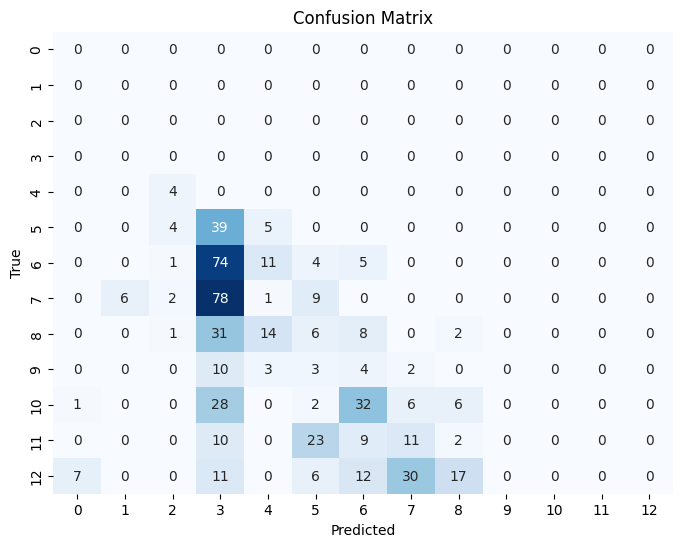


Classification Report:

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         4
           6       0.00      0.00      0.00        48
           7       0.07      0.05      0.06        95
           8       0.00      0.00      0.00        96
           9       0.07      0.03      0.04        62
          10       0.00      0.00      0.00        22
          11       0.00      0.00      0.00        75
          12       0.00      0.00      0.00        55
          13       0.00      0.00      0.00        83

    accuracy                           0.01       540
   macro avg       0.01      0.01      0.01       540
weighted avg       0.02      0.01      0.02       540



/home/buntin/jupyter-env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/buntin/jupyter-env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/buntin/jupyter-env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/buntin/jupyter-env/li

: 

: 

In [ ]:
# int_sleepinessに対するデータセット準備
X_train_sleepiness = train.drop('int_sleepiness', axis=1).drop('Sleepiness',axis=1)
y_train_sleepiness = train['int_sleepiness'] - 1

X_test_sleepiness = test.drop('int_sleepiness', axis=1).drop('Sleepiness',axis=1)
y_test_sleepiness = test['int_sleepiness'] - 1

train_data_sleepiness = lgb.Dataset(X_train_sleepiness, label=y_train_sleepiness)
test_data_sleepiness = lgb.Dataset(X_test_sleepiness, label=y_test_sleepiness, reference=train_data_sleepiness)

model = train_lgbm_classificatoin(9,train_data_sleepiness,test_data_sleepiness)

y_pred_sleepiness = model.predict(X_test_sleepiness)
y_pred_sleepiness_class = np.argmax(y_pred_sleepiness,axis=1) + 1
y_test_sleepiness += 1

acc = accuracy_score(y_test_sleepiness,y_pred_sleepiness_class)
print('Accuracy:', acc)
acc = evaluate_predictions(y_pred_sleepiness_class, y_test_sleepiness)


| Model | Accuracy(OSS) | Accuracy(Sleepiness) |
| --- | --- | ---|
| LightGBM | 0.6685 | 0.4492 |
| NN | 0.5291 | 0.2222 |
| ランダムフォレスト |  0.6074   |   0.4412  |

| モデル名 | 平均 |
| --- | --- |
| lgbm | 0.6548 |
| nn | 0.7912 |
| linear_regression | 0.6949 |
| svr |  0.7449|
| random_forest | 0.7114 |


### NeuralNetwork

Epoch 1/50
44/44 [==============================] - 1s 7ms/step - loss: 8.5845 - accuracy: 0.3655 - val_loss: 3.4695 - val_accuracy: 0.3649
Epoch 2/50
44/44 [==============================] - 0s 1ms/step - loss: 1.0952 - accuracy: 0.5712 - val_loss: 1.6808 - val_accuracy: 0.3994
Epoch 3/50
44/44 [==============================] - 0s 1ms/step - loss: 0.9740 - accuracy: 0.6101 - val_loss: 1.5046 - val_accuracy: 0.4253
Epoch 4/50
44/44 [==============================] - 0s 1ms/step - loss: 0.9478 - accuracy: 0.6129 - val_loss: 1.3354 - val_accuracy: 0.4253
Epoch 5/50
44/44 [==============================] - 0s 1ms/step - loss: 0.9319 - accuracy: 0.6101 - val_loss: 1.3869 - val_accuracy: 0.4023
Epoch 6/50
44/44 [==============================] - 0s 1ms/step - loss: 0.9197 - accuracy: 0.6302 - val_loss: 1.3255 - val_accuracy: 0.4655
Epoch 7/50
44/44 [==============================] - 0s 1ms/step - loss: 0.9537 - accuracy: 0.5935 - val_loss: 1.4595 - val_accuracy: 0.4310
Epoch 8/50
44/44 [==

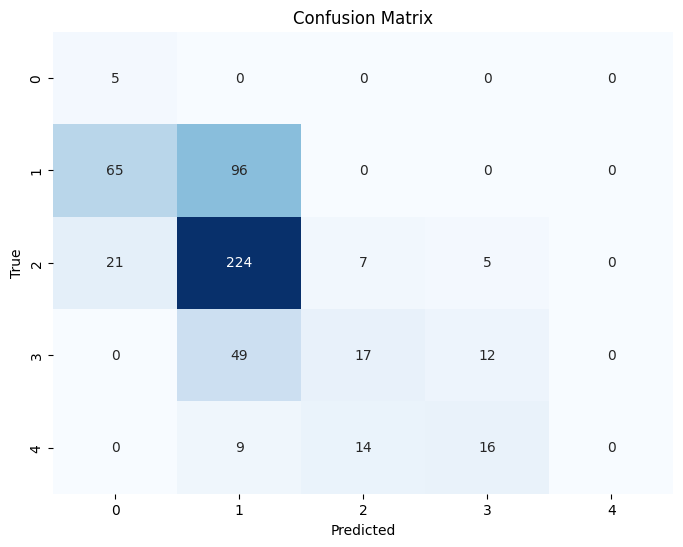


Classification Report:

              precision    recall  f1-score   support

           1       0.05      1.00      0.10         5
           2       0.25      0.60      0.36       161
           3       0.18      0.03      0.05       257
           4       0.36      0.15      0.22        78
           5       0.00      0.00      0.00        39

    accuracy                           0.22       540
   macro avg       0.17      0.36      0.14       540
weighted avg       0.22      0.22      0.16       540

0.2222222222222222


/home/buntin/jupyter-env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/buntin/jupyter-env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/buntin/jupyter-env/lib64/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


: 

: 

In [ ]:
# 1. データの準備
X_train_oss = train.drop('int_oss', axis=1).drop('oss',axis=1)
y_train_oss = train['int_oss']

X_test_oss = test.drop('int_oss', axis=1).drop('oss',axis=1)
y_test_oss = test['int_oss']


#1-5を0-4に
y_train_oss_adjusted = y_train_oss - 1
y_test_oss_adjusted = y_test_oss - 1

# ラベルをOne-Hotエンコーディング
num_class = 5
y_train_oss_cat = to_categorical(y_train_oss_adjusted, num_classes=num_class)
y_test_oss_cat = to_categorical(y_test_oss_adjusted, num_classes=num_class)

# 2. モデルの定義
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train_oss.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_class, activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 3. モデルのトレーニング
history = model.fit(X_train_oss, y_train_oss_cat, epochs=50, batch_size=32, validation_split=0.2)

# 4. 評価
predictions = model.predict(X_test_oss)
predicted_labels = np.argmax(predictions, axis=1) + 1

# acc = np.mean(predicted_labels == y_test_oss)
# print('Accuracy:', acc)
acc = evaluate_predictions(predicted_labels, y_test_oss)
print(acc)




### GraphNeuralNetwork

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

: 

: 

In [ ]:
def read_and_process(directory):
    files = os.listdir(directory)
    df_list = []
    for file in files:
        if file.endswith('.csv'):
            df = pd.read_csv(os.path.join(directory, file))
            df = df.drop(['timestamp'], axis=1)
            df = df.dropna()
            df_list.append(df)
    df_combined = pd.concat(df_list, ignore_index=True)
    return df_combined

: 

: 

In [ ]:
data_dir = 'dms_data'

train_data_path = data_dir + '/train'
test_data_path = data_dir + '/test'


train = read_and_process(train_data_path)
test = read_and_process(test_data_path)
features = ['m_speed', 'm_speed_var_480', 'm_speed_stddev_480', 'm_acceleration',
    'm_acceleration_var_480', 'm_acceleration_stddev_480', 'm_jerk',
    'm_jerk_var_480', 'm_jerk_stddev_480']

: 

: 